<a href="https://colab.research.google.com/github/Mephod1y/DataScience/blob/main/Hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [38]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [39]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [44]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.weights = tf.Variable(tf.random.normal([in_features, out_features]))
        self.biases = tf.Variable(tf.zeros([out_features]))

    def __call__(self, x, out=0):
        return tf.matmul(x, self.weights) + self.biases


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer1 = DenseLayer(num_features, n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)

    # Выходной слой
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    x = self.layer1(x)
    x = tf.nn.relu(x)
    x = self.layer2(x)
    x = tf.nn.sigmoid(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    x = self.out_layer(x)
    return tf.nn.softmax(x)

In [45]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [46]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    trainable_variables = nn.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [47]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)

        print(f"Step {step}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}")

Step 100, Loss: 238.9458, Accuracy: 0.7656
Step 200, Loss: 201.5610, Accuracy: 0.8086
Step 300, Loss: 208.8920, Accuracy: 0.8125
Step 400, Loss: 155.3926, Accuracy: 0.8359
Step 500, Loss: 140.2553, Accuracy: 0.8594
Step 600, Loss: 145.9786, Accuracy: 0.8633
Step 700, Loss: 64.7934, Accuracy: 0.9219
Step 800, Loss: 97.3715, Accuracy: 0.9219
Step 900, Loss: 66.5249, Accuracy: 0.9219
Step 1000, Loss: 76.8527, Accuracy: 0.9219
Step 1100, Loss: 106.2753, Accuracy: 0.9062
Step 1200, Loss: 71.7478, Accuracy: 0.9258
Step 1300, Loss: 72.1344, Accuracy: 0.9297
Step 1400, Loss: 62.4596, Accuracy: 0.9180
Step 1500, Loss: 89.0701, Accuracy: 0.8906
Step 1600, Loss: 86.0713, Accuracy: 0.9180
Step 1700, Loss: 94.6350, Accuracy: 0.9062
Step 1800, Loss: 103.5437, Accuracy: 0.9102
Step 1900, Loss: 57.1495, Accuracy: 0.9219
Step 2000, Loss: 40.9855, Accuracy: 0.9531
Step 2100, Loss: 43.8161, Accuracy: 0.9492
Step 2200, Loss: 59.9993, Accuracy: 0.9297
Step 2300, Loss: 66.1563, Accuracy: 0.9219
Step 2400, L

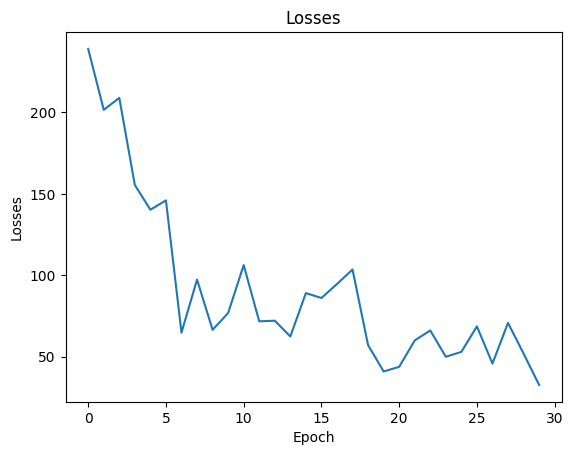

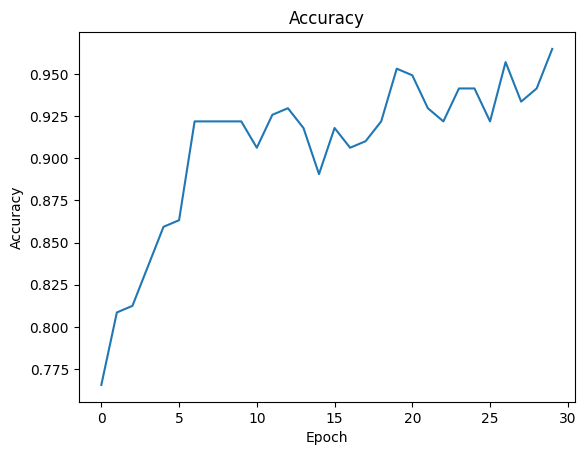

In [49]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.figure()
plt.plot(loss_history)
plt.title('Losses')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.show()

plt.figure()
plt.plot(accuracy_history)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [50]:
# Вычислите точность обученной нейросети

predict = neural_net(x_test)
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, tf.math.argmax(predict, axis=1))
m.result().numpy()

0.9018

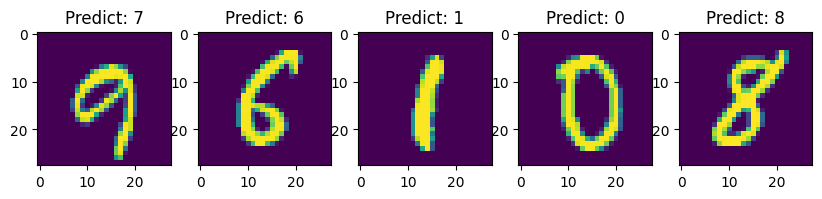

In [52]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

import random
random_choice = random.sample(range(len(x_test)), 5)
test_images = x_test[random_choice]
test_values = y_test[random_choice]

predict = neural_net(test_images)
predict_values = tf.argmax(predict, axis=1)

fig, ax = plt.subplots(1, 5)
fig.set_figheight(6)
fig.set_figwidth(10)
for i in range(len(test_images)):
    image = test_images[i].reshape((28, 28))
    value = test_values[i]
    predict_value = predict_values[i]
    ax[i].imshow(image, cmap='viridis')
    ax[i].set_title(f"Predict: {predict_value}")

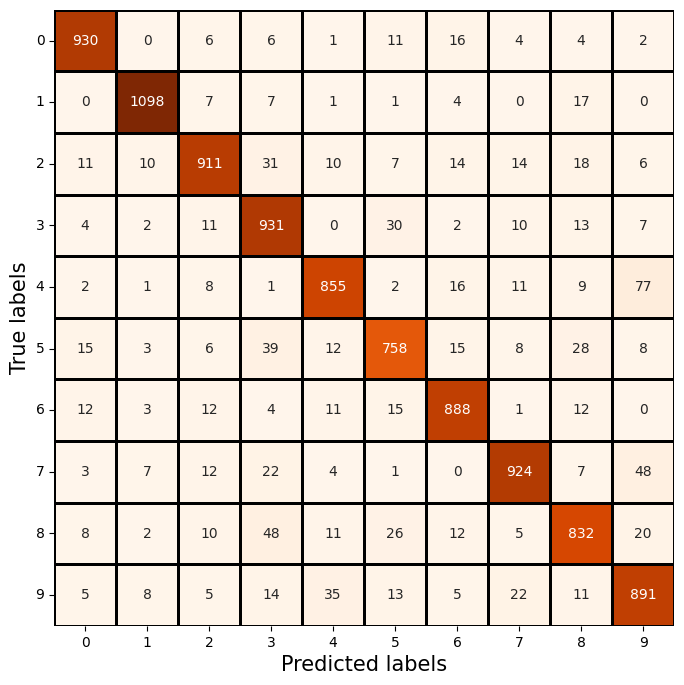

In [57]:
images_count = 10000
random_choice = random.sample(range(len(x_test)), images_count)
test_images = x_test[random_choice]
test_values = y_test[random_choice]

predict = neural_net(test_images)
predict_values = tf.argmax(predict, axis=1)

unique_labels = np.unique(np.concatenate([test_values, predict_values]))

cm = confusion_matrix(test_values, predict_values, labels=unique_labels)
df_confusion_matrix = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

plt.figure(figsize=(8, 8))
sn.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0)
plt.show()

Загалом наш нейронна мережа передбачає результати з доволі непоганою точністю 90,18%. Найчастіші помилки можна помітити на останньому графіку, де більше всього помилок в таких парах факт-предбачення як 4-9, 7-9, 8-3.